# Are we consuming more local?

## Research questions

1. Where are the products we consume in our everyday life coming from?

    - Which countries produce the primary resources (ground ingredients) consumed in Switzerland?
    - Which countries manufacture most of the products consumed in Switzerland?


2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

## Datasets

Open Food Facts (https://world.openfoodfacts.org/data)

Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

## TODO

   - Cleaning/Exploring dataset
   - Descriptive analysis
   - We should determine the list of products that are sold in Switzerland
   - We should then classify these products under different categories:
        - products entirely originating from Switzerland
        - products partially originating from Switzerland (manufactured in Switzerland but ingredients are from another country)
        - products not originating from Switzerland
   - Draw statistics from the importation balances, determining which are the countries producing most of the ground ingredients and manufacturing the products consumed in Switzerland.


In [32]:
#imports
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

import findspark
findspark.init()
import pyspark

from functools import reduce
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import to_date, last_day,date_add
from datetime import timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
DATA_FOLDER = 'data'

In [3]:
dataset_main = spark.read.csv(DATA_FOLDER+"/en.openfoodfacts.org.products.csv", header=True, mode="DROPMALFORMED", sep = '\t')

In [4]:
dataset_main.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable 

In [5]:
#Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse”
df_ev_conso = pd.read_excel(DATA_FOLDER+"/je-f-07.06.02.xlsx", header=4, sheet_name='Dès 2007')
df_ev_conso = df_ev_conso.dropna(how='all')

In [6]:
#Additional datasets “Dépenses fédérales pour l’agriculture et l’alimentation” 
dep_fed_al = pd.read_excel(DATA_FOLDER+"/je-f-07.02.03.02.04.xlsx", header=3, sheet_name='T 07.02.03.02.04')
dep_fed_al = dep_fed_al.dropna(how='all')

In [7]:
#For the sake of the project, we will focus on features related to the origin of the manufacture and ingredients of the products
dataset_main.createOrReplaceTempView("data_main")
focus_df = spark.sql("SELECT product_name, brands, brands_tags, categories, categories_tags, origins, origins_tags, manufacturing_places, manufacturing_places_tags,labels,labels_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags FROM data_main")
#focus_df.show()

In [8]:
#create a specific filter for Swiss occurences
filter_ch = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra'
#store products that are sold in Switzerland
swiss_sold_data = focus_df.filter(focus_df["countries"].rlike(filter_ch))
#store products which ingredients originate from Switzerland
swiss_origin_data = focus_df.filter(focus_df["origins"].rlike(filter_ch))
#store products that are manufactured in Switzerland
swiss_manu_data = focus_df.filter(focus_df["manufacturing_places"].rlike(filter_ch))
#store products that are both manufactured and originate from Switzerland
swiss_origin_manu_data = focus_df.filter(focus_df["origins"].rlike(filter_ch) & focus_df["manufacturing_places"].rlike(filter_ch))

In [9]:
######## DATA PREPARATION FOR PIE ########
#
#count products whose ingredients from switzerland but which were not manufactured in Switzerland
swiss_origin_tot = swiss_origin_data.filter(~ swiss_origin_data["manufacturing_places"].rlike(filter_ch)).count()
#Total of products sold in Switzerland
swiss_sold_tot = swiss_sold_data.count()
#count products that do not have swiss ingredients
swiss_manu_tot = swiss_manu_data.filter(~ swiss_manu_data["origins"].rlike(filter_ch)).count()
#products that are sold in Switzerland but that were not manufactured in CH and that do not have swiss ingredients
non_swiss_sold_tot = swiss_sold_data.filter(~ swiss_sold_data["manufacturing_places"].rlike(filter_ch) & ~swiss_sold_data["origins"].rlike(filter_ch)).count()
#total of products that are both manufactured and has ingredients from Switzerland
swiss_origin_manu_tot = swiss_origin_manu_data.count()


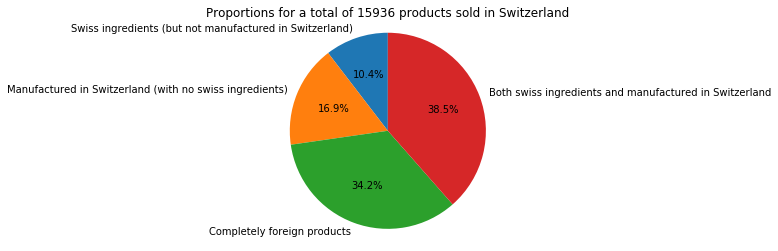

In [10]:
labels = 'Swiss ingredients (but not manufactured in Switzerland)', 'Manufactured in Switzerland (with no swiss ingredients)', 'Completely foreign products', 'Both swiss ingredients and manufactured in Switzerland'
sizes = [swiss_origin_tot, swiss_manu_tot, non_swiss_sold_tot, swiss_origin_manu_tot]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions for a total of ' + str(swiss_sold_tot) + ' products sold in Switzerland')

plt.show()

In [11]:
#About foreign products
#Store products that are neither manufactured nor have ingredients from Switzerland
non_swiss_sold = swiss_sold_data.filter(~ swiss_sold_data["manufacturing_places"].rlike(filter_ch) & ~swiss_sold_data["origins"].rlike(filter_ch))

In [12]:
non_swiss_sold.createOrReplaceTempView("non_swiss_sold")
non_swiss_categories = spark.sql("SELECT origins, COUNT(origins) FROM non_swiss_sold GROUP BY origins")

The dataset is not concistent with the country or places name, therefore, we have to clean the data by trying to unify a maximum the places names. The database http://download.geonames.org/export/dump/ is used in order to match all the different way of naming a country to a single convention

In [13]:
#cleaning up the different foreign countries to better count them
non_swiss_categories = non_swiss_categories.withColumn('origins', F.explode_outer(F.split('origins', ',')))
non_swiss_categories = non_swiss_categories.withColumn('origins', F.regexp_replace('origins', ',|\\?', ''))

In [39]:
#Import dataset country from http://download.geonames.org/export/dump/
dataset_country_names = spark.read.option("header", "false") \
    .option("delimiter", '\t') \
    .option("inferSchema", "true") \
    .csv(DATA_FOLDER+"/allCountries.txt")

In [42]:
#Import all the alternativeNames from the dataset http://download.geonames.org/export/dump/ 
dataset_alt_names = spark.read.option("header", "false") \
    .option("delimiter", '\t') \
    .option("inferSchema", "true") \
    .csv(DATA_FOLDER+"/alternateNames.txt")

In [89]:
#Arrange the dataset with correct column names (the dataset is under the form of a txt file with no header)
#Header names are directly retrieved from the siteweb explanations
oldColumns = dataset_country_names.schema.names
newColumns = ["geonameid", "name", "asciiname","alternatenames","latitude","longitude","feature_class", "feature_code", "country_code","cc2","admin1_code","admin2_code","admin3_code","admin4_code","population","elevation","dem","timezone","modification_date"]

dataset_country_names = reduce(lambda dataset_country_names, idx: dataset_country_names.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), dataset_country_names)
dataset_country_names.printSchema()

root
 |-- geonameid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- asciiname: string (nullable = true)
 |-- alternatenames: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- feature_class: string (nullable = true)
 |-- feature_code: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- cc2: string (nullable = true)
 |-- admin1_code: string (nullable = true)
 |-- admin2_code: string (nullable = true)
 |-- admin3_code: string (nullable = true)
 |-- admin4_code: string (nullable = true)
 |-- population: long (nullable = true)
 |-- elevation: integer (nullable = true)
 |-- dem: integer (nullable = true)
 |-- timezone: string (nullable = true)
 |-- modification_date: timestamp (nullable = true)



In [92]:
#Arrange the dataset with correct column names (the dataset is under the form of a txt file with no header)
#Header names are directly retrieved from the siteweb explanations
oldColumns = dataset_alt_names.schema.names
newColumns = ["alternateNameId", "geonameid", "isolanguage","alternate_name","isPreferredName","isShortName","isColloquial", "isHistoric", "from","to"]

dataset_alt_names = reduce(lambda dataset_alt_names, idx: dataset_alt_names.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), dataset_alt_names)
dataset_alt_names.printSchema()

root
 |-- alternateNameId: integer (nullable = true)
 |-- geonameid: integer (nullable = true)
 |-- isolanguage: string (nullable = true)
 |-- alternate_name: string (nullable = true)
 |-- isPreferredName: integer (nullable = true)
 |-- isShortName: integer (nullable = true)
 |-- isColloquial: integer (nullable = true)
 |-- isHistoric: integer (nullable = true)



In [101]:
#Create temporary View for SQL work
non_swiss_categories.createOrReplaceTempView("non_swiss_data")
dataset_country_names.createOrReplaceTempView("country_names")

In [57]:
#Here we match all the alternative names with the alternateName dataset, we add a column with corresponding name id
dataset_alt_names.createOrReplaceTempView("alter_names")
non_swiss_renamed = spark.sql("SELECT d1.origins, d2.geonameid FROM non_swiss_data d1, alter_names d2 WHERE d2.alternate_name LIKE d1.origins")

In [49]:
non_swiss_renamed.show()

+----------------+---------+
|         origins|geonameid|
+----------------+---------+
|            Inde|  2896125|
|            Inde|  1269750|
|            Inde|  1269750|
|            Inde|  1269750|
|            Inde|  1322163|
|            Inde|  1322171|
|            Inde|  8767343|
|            Inde|  8767346|
|          France|  8052720|
|          France|  8226141|
|  Maine-et-Loire|  2996663|
|  Maine-et-Loire|  2996663|
|  Maine-et-Loire|  2996663|
|Pays de la Loire|  2988289|
|Pays de la Loire|  2988289|
|Pays de la Loire|  2988289|
|          France|  3017382|
|          France|  3017382|
|          France|  3017382|
|          France|  3017382|
+----------------+---------+
only showing top 20 rows



In [81]:
non_swiss_renamed.createOrReplaceTempView("country_id_names")

In [124]:
#Match the id with the name in the allCountries dataset --this took approx. 50 minutes to compute
non_swiss_db = spark.sql("SELECT country_id_names.origins, country_names.country_code FROM country_id_names LEFT JOIN country_names ON country_id_names.geonameid = country_names.geonameid")
non_swiss_db.show()

+----------+------------+
|   origins|country_code|
+----------+------------+
|   Tunisie|          TN|
|   Tunisie|          TN|
|  Tunesien|          TN|
|  Tunesien|          TN|
|  Tunesien|          TN|
|     China|          AE|
|     China|          AE|
|     China|          AE|
|   England|          NO|
|     Alpes|          CO|
|  Paraguay|          CL|
|  Paraguay|          CL|
|     Chili|          SY|
|     Maroc|          MA|
|     Maroc|          MA|
|     Maroc|          MA|
|     Maroc|          MA|
|     Maroc|          MA|
|     Maroc|          MA|
|Angleterre|          GB|
+----------+------------+
only showing top 20 rows



In [103]:
#save that in csv files
non_swiss_db.write.csv('non_swiss_country_names.csv')           

In [126]:
non_swiss_db.createOrReplaceTempView("non_swiss_origins")
non_swiss_tot = spark.sql("SELECT country_code, COUNT(country_code) AS tot FROM non_swiss_origins GROUP BY country_code")

In [127]:
non_swiss_pd = non_swiss_tot.toPandas() 

In [138]:
non_swiss_pd_sorted.tot

46    382
87    246
19    126
89    121
41    120
13    113
54    102
24     91
21     80
69     74
60     73
82     73
44     71
14     62
20     50
47     48
36     42
79     41
32     35
81     34
22     28
26     24
27     21
35     21
43     18
16     17
64     17
10     17
28     15
23     15
     ... 
52      3
83      3
50      3
8       2
18      2
91      2
30      2
92      2
33      2
0       2
48      2
71      2
70      2
40      2
51      2
66      2
56      2
1       2
34      1
90      1
3       1
88      1
84      1
7       1
61      1
75      1
62      1
42      1
53      1
17      0
Name: tot, Length: 94, dtype: int64

TypeError: None is not a string

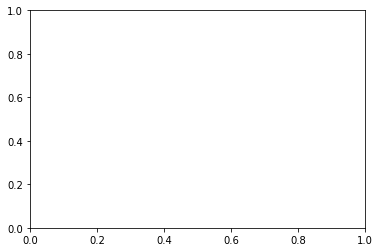

In [139]:
fig, ax = plt.subplots()
plt.bar(non_swiss_pd_sorted.country_code, non_swiss_pd_sorted.tot)
plt.ylabel('Total')  
plt.xlabel('Countries')  
plt.xticks(non_swiss_pd_sorted.country_code, rotation='vertical')
plt.title('Origin of 10 bigger ingredients imports')
plt.show()

In [128]:
non_swiss_pd_sorted = non_swiss_pd.sort_values(by=['tot'], ascending=False)
twenty_bigger_import = non_swiss_pd_sorted.head(20)

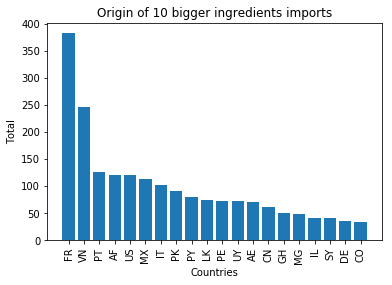

In [130]:
fig, ax = plt.subplots()
plt.bar(twenty_bigger_import.country_code, twenty_bigger_import.tot)
plt.ylabel('Total')  
plt.xlabel('Countries')  
plt.xticks(twenty_bigger_import.country_code, rotation='vertical')
plt.title('Origin of 10 bigger ingredients imports')
plt.show()

In [ ]:
#RUBISH
non_swiss_categories.createOrReplaceTempView("non_swiss_categories")
non_swiss_origins = spark.sql("SELECT origins, CASE WHEN origins ='^Ita|Italie$' THEN 'Italy'\
WHEN origins REGEXP '^[Ff]r' THEN 'France' \
WHEN origins REGEXP '^[Gg]e|^[Dd]e|^[Aa]l' THEN 'Germany' \
WHEN origins REGEXP '^[Bb]ul' THEN 'Bulgary' \
WHEN origins REGEXP '^[Aa]r' THEN 'Argentinia' \
WHEN origins REGEXP '^[Pp]ar' THEN 'Paraguay' \
WHEN origins REGEXP '^[Aa]ut|^[Oo]es|Austria' THEN 'Austria' \
WHEN origins REGEXP '^[Rr]o' THEN 'Romania' \
WHEN origins REGEXP '^[Ii]nd' THEN 'India' \
WHEN origins REGEXP '^Pays Bas|^[Nn]eth|^[Nn]ieder|^[Hh]oll' THEN 'Netherlands'\
WHEN origins REGEXP '^Esp|^Spain$|^Span' THEN 'Spain'\
WHEN origins REGEXP '^Bel' THEN 'Belgium'\
WHEN origins REGEXP '^Port|Portugal$' THEN 'Portugal'\
WHEN origins REGEXP '^Rus' THEN 'Russia' ELSE ''+ origins END AS Countries_origin FROM non_swiss_categories")
non_swiss_origins.show(20)
non_swiss_origins = non_swiss_origins.withColumn("Countries_origin",coalesce(non_swiss_origins.Countries_origin,non_swiss_origins.origins))